In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import tree
%matplotlib inline
from selenium import webdriver as wd
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
import datetime

Data Crawling Part
---------------------------
*In this Part we are going to collect our data.

*The crawling is a selenium crawling from the 'www.kayak.com' website.


Open Web function
------------------
*Open web is a function that gets departure country(dep_country), the destination country(des_country), departure date(dep_date), ticket type (category) - there are three ticket search in the website - Cheapest/Best/Quickest
            and finally the web driver - we use the chrome driver..
    
*This function builds a url from the parameters it gets, and commands the driver to open the webpage.
***&fs=legdur=-720;airlines=-MULT,flylocal - defines the airlines not to be multiple, and that duration will be until 12h

In [2]:
def open_web(dep_country, des_country, dep_date, category,driver):
    url = ('https://www.kayak.com/flights/' + dep_country + '-' + des_country + '/' +
          dep_date + '/?sort=' + category + '&fs=legdur=-720'+ ';airlines=-MULT'+',flylocal')
    driver.get(url)

More Button
-------------------
*when searching for tickets in the kayak website there is a button 'Show more results', more_button function is a function that gets the clicking number on this button parameter(more_results_button) - that will command the driver click on this button 'number times'

In [3]:
def more_button(more_results_button,driver):
    for i in range(more_results_button):
        try:
            time.sleep(1.5)
            driver.find_element_by_xpath('//a[@class="moreButton"]').click()
        except:
            time.sleep(2)

try except xpath
------------------------
When we need to get elements we need to the webpage be opened.
This function gets xpath of the elements we must collect and two different times - normal and critical.
the code will wait normal_time time, then gets the elements, sometimes the webpage takes more seconds to be loaded,
            so if the normal_time waiting is going to get error, we will wait another cirical_time time and then collect the elements.

In [4]:
def try_except_xpath(normal_time, critical_time, xpath, driver):
    try:
        time.sleep(normal_time)
        element = driver.find_elements_by_xpath(xpath)
    except:
        time.sleep(critical_time)
        element = driver.find_elements_by_xpath(xpath)
    finally:
        return element

Get Times
-------------
When the webpage is opened we gets depart and arrival times element, collecting the text from them into two lists.

In [5]:
def Get_Times(driver):
    Depart_elements = try_except_xpath(0.5,2,'\
    //span[@class="depart-time base-time"]',driver)
    Arrival_elements = try_except_xpath(0.5,2,'\
    //span[@class="arrival-time base-time"]',driver)
    Departure_Time = []
    Arrival_Time = []
    for i in range(len(Depart_elements)):
        Departure_Time.append(Depart_elements[i].text)
        Arrival_Time.append(Arrival_elements[i].text)
    return Departure_Time, Arrival_Time

Get Durations
--------------
When the webpage is opened we gets duration element, collecting the text from them into two lists.


In [6]:
def Get_Durations(driver):
    durations = try_except_xpath(0.5,2, '\
    //div[@class="section duration allow-multi-modal-icons"]\
    /div[@class="top"]',driver)
    Duration = []
    for i in range(len(durations)):
        Duration.append(durations[i].text)
    return Duration

Get Airport Code
-----------------
This function gets a raw test of an airport and takes the first three letters of it.
For example: (raw_airport = 'TLV Ben Gurion int') and turns this into (airport = 'TLV')

In [7]:
def Get_Airport_Code(raw_airport):
    pattern = '(\w\w\w) .*'
    airport = re.findall(pattern,raw_airport)[0]
    return airport

Get Airports
----------------
When the webpage is opened we get by one xpath the source and the destination airport elements. Then we must separate them into two lists and get the 3 first letters of the airport name (Get_Airport_Code function) 

In [8]:
def Get_Airports(driver):
    airports = try_except_xpath(0.5,2, '//span[@class="airport-name"]',driver)
    Source_Airports = []
    Destination_Airports = []
    for i in range(len(airports)//2):
        try:
            airport = airports[2*i].text
            Source_Airports.append(Get_Airport_Code(airport))
        except:
            Source_Airports.append(np.nan)
        try:
            airport = airports[1+2*i].text
            Destination_Airports.append(Get_Airport_Code(airport))
        except:
            Destination_Airports.append(np.nan)
    return Source_Airports, Destination_Airports

Get Stops
----------------
When the webpage is opened we get the number of stops, and the stops elements. After this we collect the text from those elements.

In [9]:
def Get_Stops(driver):
    stops_num = try_except_xpath(0.5,2, '\
    //div[@class="section stops"]/div[@class="top"]',driver)
    stops_cities = try_except_xpath(0.5,2, '\
    //div[@class="section stops"]/div[@class="bottom"]',driver)
    Stops_Number = []
    Route = []
    for i in range(len(stops_num)):
        Stops_Number.append(stops_num[i].text)
        Route.append(stops_cities[i].text)
    return Stops_Number, Route

Get Price
-----------------
When the webpage is opened we get the Price elements. After this we collect the text from those elements.

In [10]:
def Get_Price(driver):
    ticket_price = try_except_xpath(0.5,2, '\
    //div[@class="booking"]//span[@class="price-text"]',driver)
    Price = []
    for ticket in ticket_price:
        Price.append(ticket.text[1:])
    return Price

Get Airlines
--------------
When the webpage is opened we get the Airline elements. After this we collect the text from those elements.

In [11]:
def Get_Airlines(driver):
    airline = try_except_xpath(0.5,2,'\
    //div[@class="section codeshares allow-airlines"]/\
    span[@class="codeshares-airline-names"]',driver)
    Airlines = []
    for line in airline:
        Airlines.append(line.text)
    return Airlines

Crawling Page
--------------------
This function takes the the lists of the ticket data, by each function we described before. And returns a list of lists of the data we collected.

In [12]:
def crawling_page(driver):
    # getting list of the times of each flight (departure and arrival)
    time.sleep(1)
    Departure_Time, Arrival_Time = Get_Times(driver)
    # getting list of the durations of each flight
    time.sleep(1)
    Durations = Get_Durations(driver)
    # getting list of the airports we departure and arrive
    time.sleep(1)
    Source_Airport, Destination_Airport = Get_Airports(driver)
    # getting list of number and places of stops
    time.sleep(1)
    Stops_Number, Route = Get_Stops(driver)
    # getting the prices of the flights
    time.sleep(1)
    Price = Get_Price(driver)
    # getting the airlines of the flights
    time.sleep(1)
    Airlines = Get_Airlines(driver)
    return [Airlines, Source_Airport, Destination_Airport, Route, Departure_Time, Arrival_Time, Durations, 
           Stops_Number, Price]

Write To CSV
-------------------
Sometimes the crawling data can be interupted and stoped by internet,electricity causes and etc...
So it be easier to begin the process from the point we stopped and not to begin itself from the start. This why we save each page into our data
This function recives a dictionary for the page tickets data we crawled, creates from it a df, and saves it with the other data we collected before.

In [13]:
def Write_To_CSV(normal_page_dic):
    try:
        Df = pd.DataFrame(normal_page_dic)
        Saved_DF = pd.read_csv('CrawlingData1.csv')
        New_df = pd.concat([Saved_DF,Df])
        New_df.to_csv('CrawlingData1.csv',index=False)
    except:
        Df.to_csv('CrawlingData1.csv',index=False)

Crawl Data
-----------------
This function gets the departure countries as a list, the destination countries, the departure dates, and the more_results_button for the more_button function.
We run on all of the option that can be between departure countries, destination countries and dates. For example:

    1.depart_countries = ['israel'], destination_countries = ['italy','denmark'], date = [3/6/2023].
    
    2.Our option are: israel->italy(3/6/2023),israel->denmark(3/6/2023)
    
    3.Then we run for each ticket category(Chepest/Best/Quickest) for each variation the algorithm below:
    
    4.step 1: open the webpage using open_web function.
    
    5.step 2: load more tickets in current webpage by clicking on the 'show more results' using more_button function.
    
    6.step 3: crawl and get the data from this page.
    
    7.step 4: if each list of the data is the same lengh use Write_CSV function to save the collected data as a dataframe.
        
repeat the steps 1-4 for each variation, and restart the driver for each run (sometimes the websites wants the check if we are not robots. this prevents us from collecting the data.)

In [14]:
def Crawl_data(departure_countries ,countries ,dates, more_results_button):
    for dep_country in departure_countries:
        for country in countries:
            path = r'C:/Users/EvyatarPeretz/Desktop/mystuff/studies/chromedriver_win32/chromedriver'
            driver = wd.Chrome(path)
            if country!=dep_country:
                for date in dates:
                    for category in ['price_a','bestflight_a','duration_a']:
                        try:
                            time.sleep(1)
                            open_web(dep_country, country,
                                     date, category, driver)
                        except:    
                            time.sleep(3)
                            open_web(dep_country, country,
                                     date, category, driver)
                        try:
                            time.sleep(2)
                            more_button(more_results_button, driver) 
                        except:
                            pass
                        try:
                            time.sleep(2)
                            page_info = crawling_page(driver)
                        except:
                            time.sleep(3)
                            page_info = crawling_page(driver)
                        try:
                            for x in page_info:
                                for y in page_info:
                                    if(len(x)!=len(y)):
                                        raise Exception('Wrong_Lenghts')
                            lengh = len(page_info[0])
                            dic = {
                                'Airline': page_info[0],
                                'Date':([date]*lengh),
                                'Source_Airport': page_info[1],
                                'Destination_Airport': page_info[2],
                                'Route': page_info[3],
                                'Departure_Time': page_info[4],
                                'Arrival_Time': page_info[5],
                                'Duration': page_info[6],
                                'Stops_Number': page_info[7],
                                'Price': page_info[8]
                            }
                            Write_To_CSV(dic)
                        except:
                            pass                        
            driver.close()
            time.sleep(1)

The Main Crawling Run
---------------------


In [15]:
# 118cy = Italy, 90cy = Germany, 15cy = Austria 
# 225cy = Spain, 82cy = France, 94cy = Greece
# 24cy = Belgium, 174cy = Netherlands
# 252cy = UK, 65cy = Denmark
# 233cy = Switzerland
# 116cy = Ireland, 117cy = Israel
# june =    ['2022-06-01','2022-06-02','2022-06-03','2022-06-04','2022-06-05','2022-06-06',
#             '2022-06-07','2022-06-08','2022-06-09','2022-06-10',
#             '2022-06-11','2022-06-12','2022-06-13','2022-06-14','2022-06-15','2022-06-16',
#             '2022-06-17','2022-06-18','2022-06-19','2022-06-20',
#             '2022-06-21','2022-06-22','2022-06-23','2022-06-24','2022-06-25','2022-06-26',
#             '2022-06-27','2022-06-28','2022-06-29','2022-06-30']
# Crawl_data(['117cy'],
#            ['118cy','90cy'], 
#             ['2022-07-01','2022-07-02'], 3)

The Data Analysis Part
----------------------
In this Part we are going to clean and analyse our data.
Then we are going to build models and see which one is the best fit for our dataset.

In [16]:
df = pd.read_csv('Crawled_Data1.csv')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15972 entries, 0 to 15971
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Airline              15972 non-null  object
 1   Date                 15972 non-null  object
 2   Source_Airport       15972 non-null  object
 3   Destination_Airport  15972 non-null  object
 4   Route                13851 non-null  object
 5   Departure_Time       15972 non-null  object
 6   Arrival_Time         15972 non-null  object
 7   Duration             15972 non-null  object
 8   Stops_Number         15972 non-null  object
 9   Price                15972 non-null  object
dtypes: object(10)
memory usage: 1.2+ MB


First Analyze and gooding
-------------------------

Dropping Duplicates
----------------------------

In [18]:
df.drop_duplicates(inplace = True)
print(f'The shape is: {df.shape}\n')
print(f'Features amount: {df.shape[0]*df.shape[1]}')

The shape is: (7266, 10)

Features amount: 72660


Well, it's significantly reduced our data, but we still have a fair amount of data 
Now, we will convert the data into a form that will help us analyze and understand the data
In order to discretize the price column, we will convert it to int and round the data to the nearest hundredth. Thus when we predict a price, we predict the price category to which it belongs. For example, between 200 and 300 NIS 

In [19]:
def Price_To_Int(df):
    df2 = df.copy()
    df2['Price'] = df2['Price'].apply(lambda x:int(x.replace(',','')))
    df2 = df2.round({'Price':-2})
    return df2

In [20]:
df = Price_To_Int(df)

In [21]:
df['Price'].unique()

array([ 300,  200,  500,  800,  400,  700,  600,  900, 1000, 1200, 1300,
       1400, 1500, 1600, 1800, 2000, 2100, 2200, 2400, 2600, 3300, 1100,
       1700, 1900, 2300, 2500, 3100, 2700, 2800, 2900, 4600, 3900, 4300,
       3000, 3400, 5400, 6000, 4700, 4800, 5000, 4200, 3200, 5700, 9300,
       4400, 5100, 5500, 3500, 3600, 5600, 6400, 4100, 5800, 5200, 5300,
       4500, 6800, 7800, 7400, 6100, 7900, 8400, 3700, 3800, 6900, 4000,
       7300,  100,    0, 6300, 4900, 9400], dtype=int64)

Now, we will split the date by day and month. The year is not critical as we have only acquired data from 2022

In [22]:
df['Day'] = pd.to_datetime(df['Date'],format='%m/%d/%Y').dt.day
df['Month'] = pd.to_datetime(df['Date'],format='%m/%d/%Y').dt.month
df.drop('Date',axis=1,inplace=True)

Now we split the time form by hours and minuts

In [23]:
df['Dep_hour'] = pd.to_datetime(df.Departure_Time).dt.hour
df['Dep_min'] = pd.to_datetime(df.Departure_Time).dt.minute
df.drop('Departure_Time',axis=1,inplace=True)

In [24]:
df['Arr_hour'] = pd.to_datetime(df.Arrival_Time).dt.hour
df['Arr_min'] = pd.to_datetime(df.Arrival_Time).dt.minute
df.drop('Arrival_Time',axis=1,inplace=True)

In [25]:
df.head()

,Airline,Source_Airport,Destination_Airport,Route,Duration,Stops_Number,Price,Day,Month,Dep_hour,Dep_min,Arr_hour,Arr_min
0,Wizz Air,TLV,FCO,NaN,3h 45m,nonstop,300,9,5,11,25,14,10
1,Wizz Air,TLV,FCO,NaN,3h 45m,nonstop,200,9,5,11,25,14,10
2,EL AL,TLV,FCO,NaN,3h 40m,nonstop,500,9,5,18,0,20,40
3,Arkia,TLV,FCO,NaN,3h 40m,nonstop,500,9,5,8,25,11,5
4,ITA Airways,TLV,FCO,NaN,3h 45m,nonstop,800,9,5,15,15,18,0


Currently the "Duration" column contains values ​​of the form Xh Ym and we want to split the column into hours and minutes. We will use regex to do this also we will combine the hours and mintues on Split_Sum_Duration function.

In [26]:
def Get_Duration(duration):
    pattern = '(.*)h (.*)m'
    hours = re.findall(pattern,duration)[0][0]
    mins = re.findall(pattern,duration)[0][1]
    return hours,mins

In [27]:
def Split_Sum_Duration(df):
    df2 = df.copy()
    df2['Duration_Hours'] = df2['Duration'].apply(lambda x:int(Get_Duration(x)[0]))
    df2['Duration_Minutes'] = df2['Duration'].apply(lambda x:int(Get_Duration(x)[1]))
    df2['Sum_Duration'] = df2['Duration_Hours'] + (df2['Duration_Minutes']/60)
    df2 = df2.round({'Sum_Duration':2})
    df2.drop(['Duration','Duration_Hours','Duration_Minutes'], inplace=True, axis=1)
    
    return df2

In [28]:
df = Split_Sum_Duration(df)

In [29]:
df.head()

,Airline,Source_Airport,Destination_Airport,Route,Stops_Number,Price,Day,Month,Dep_hour,Dep_min,Arr_hour,Arr_min,Sum_Duration
0,Wizz Air,TLV,FCO,NaN,nonstop,300,9,5,11,25,14,10,3.75
1,Wizz Air,TLV,FCO,NaN,nonstop,200,9,5,11,25,14,10,3.75
2,EL AL,TLV,FCO,NaN,nonstop,500,9,5,18,0,20,40,3.67
3,Arkia,TLV,FCO,NaN,nonstop,500,9,5,8,25,11,5,3.67
4,ITA Airways,TLV,FCO,NaN,nonstop,800,9,5,15,15,18,0,3.75


In [30]:
df['Stops_Number'].unique()

array(['nonstop', '1 stop', '2 stops', '3 stops'], dtype=object)

The flights we purchased have direct flights, one-stop flights, two-stop flights and 3-stop flights. We will convert the strings to int which represents the number of stops: 0-3 

In [31]:
df.replace({'nonstop':0,'1 stop':1,'2 stops':2,'3 stops':3}, inplace=True)

now we convert the rest of our data into numerical type

In [32]:
def Cols_Into_Int(df, cols):
    l = []
    df2 = df.copy()
    for col in cols:
        l = list(df2[col])
        unique_list = np.unique(l)
        dic = {}
        for i,x in enumerate(unique_list):
            dic[x] = i+2
        df2.replace(dic, inplace=True)
    return df2

In [33]:
df = Cols_Into_Int(df,['Airline','Source_Airport','Destination_Airport','Route'])

 we drop non critical columns 

In [34]:
df.drop(['Dep_min','Arr_min'], axis=1,inplace=True)
df

,Airline,Source_Airport,Destination_Airport,Route,Stops_Number,Price,Day,Month,Dep_hour,Arr_hour,Sum_Duration
0,46,3,18,NaN,0,300,9,5,11,14,3.75
1,46,3,18,NaN,0,200,9,5,11,14,3.75
2,15,3,18,NaN,0,500,9,5,18,20,3.67
3,8,3,18,NaN,0,500,9,5,8,11,3.67
4,22,3,18,NaN,0,800,9,5,15,18,3.75
...,...,...,...,...,...,...,...,...,...,...,...
15943,11,3,29,22.0,1,1200,1,4,16,23,9.08
15944,42,3,14,68.0,1,1200,1,4,8,15,9.33
15945,34,3,14,38.0,1,1400,1,4,4,11,9.00
15946,27,3,14,19.0,1,1400,1,4,16,22,7.67


In [35]:
df.dropna(inplace=True)
df.info()
df.to_csv('DataAfterManipulation.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6276 entries, 5 to 15947
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Airline              6276 non-null   int64  
 1   Source_Airport       6276 non-null   int64  
 2   Destination_Airport  6276 non-null   int64  
 3   Route                6276 non-null   float64
 4   Stops_Number         6276 non-null   int64  
 5   Price                6276 non-null   int64  
 6   Day                  6276 non-null   int64  
 7   Month                6276 non-null   int64  
 8   Dep_hour             6276 non-null   int64  
 9   Arr_hour             6276 non-null   int64  
 10  Sum_Duration         6276 non-null   float64
dtypes: float64(2), int64(9)
memory usage: 588.4 KB


IQR
-----------
Now, that all of our data is type int, we continue to outliers detection
As we can see, we have a lot of outliers, and the range of them is different per country. We use IQR to reduce them

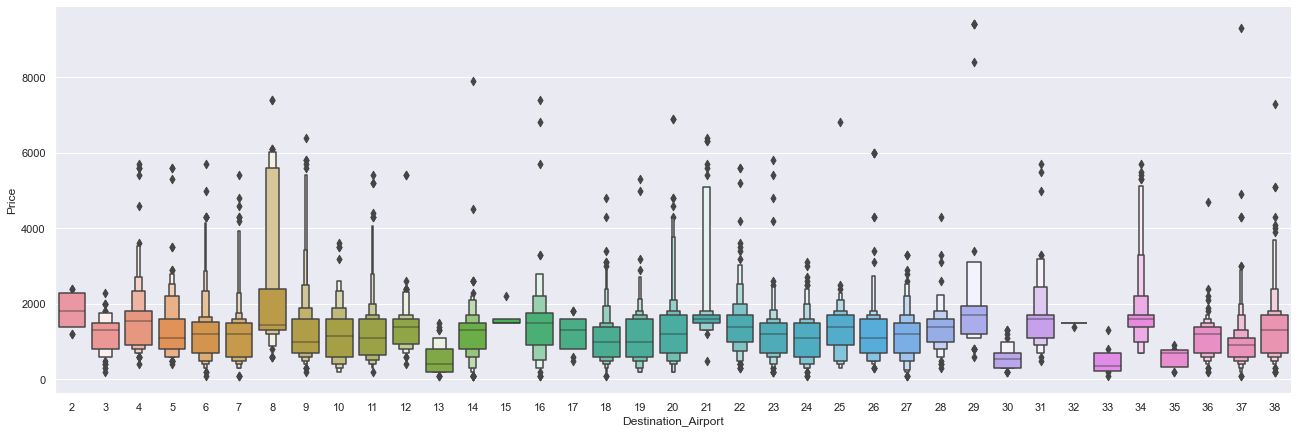

In [36]:
sns.set()
sns.catplot(y = "Price", x = "Destination_Airport", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

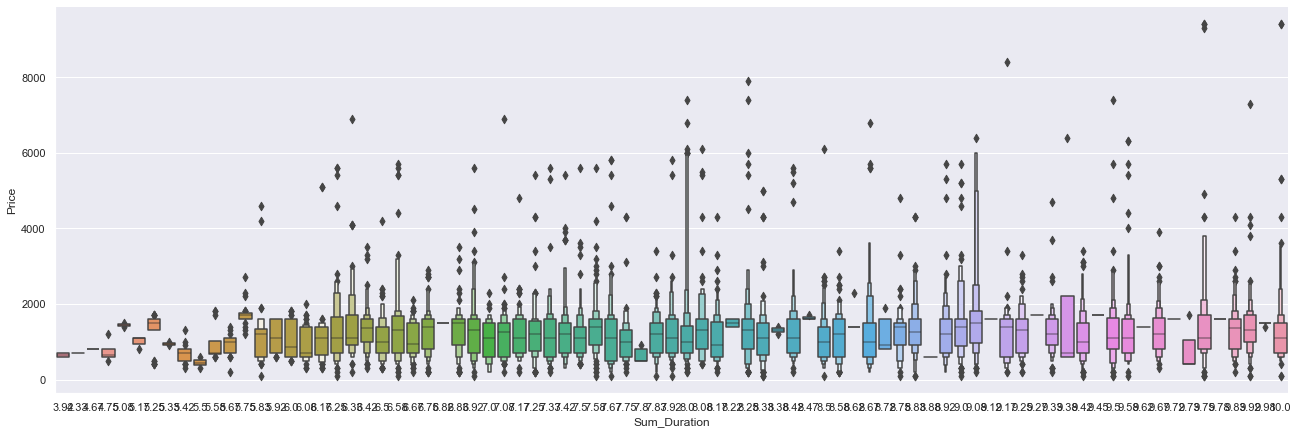

In [37]:
sns.set()
sns.catplot(y = "Price", x = "Sum_Duration", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

as we can see, we have a lot of outliers, and the range of them is different per country. We use IQR per country to reduce them

In [38]:
def Outlier_Detection_IQR(df, cols):
    df2 = df.copy()
    for col in cols:
        for airport in df2['Destination_Airport'].unique():
            Q1 = np.percentile(df2[df2['Destination_Airport']==airport][col], 25)
            Q3 = np.percentile(df2[df2['Destination_Airport']==airport][col], 75)
            IQR = Q3 - Q1
            IQR_range = 1.5 * IQR
            df2.loc[(df2['Destination_Airport']==airport)&((df2[col] < Q1 - IQR_range) | (df2[col] > Q3 + IQR_range)), [col]] = np.nan
    return df2

In [39]:
df = Outlier_Detection_IQR(df, ['Price','Sum_Duration'])
df.dropna(inplace=True)
df

,Airline,Source_Airport,Destination_Airport,Route,Stops_Number,Price,Day,Month,Dep_hour,Arr_hour,Sum_Duration
5,46,3,27,97.0,1,400.0,9,5,9,14,6.25
6,2,3,18,5.0,1,700.0,9,5,5,9,5.42
8,32,3,36,37.0,1,600.0,9,5,12,20,9.58
9,46,3,18,104.0,1,600.0,9,5,11,20,9.67
10,48,3,18,20.0,1,700.0,9,5,13,20,8.25
...,...,...,...,...,...,...,...,...,...,...,...
15943,11,3,29,22.0,1,1200.0,1,4,16,23,9.08
15944,42,3,14,68.0,1,1200.0,1,4,8,15,9.33
15945,34,3,14,38.0,1,1400.0,1,4,4,11,9.00
15946,27,3,14,19.0,1,1400.0,1,4,16,22,7.67


graphs, After the IQR

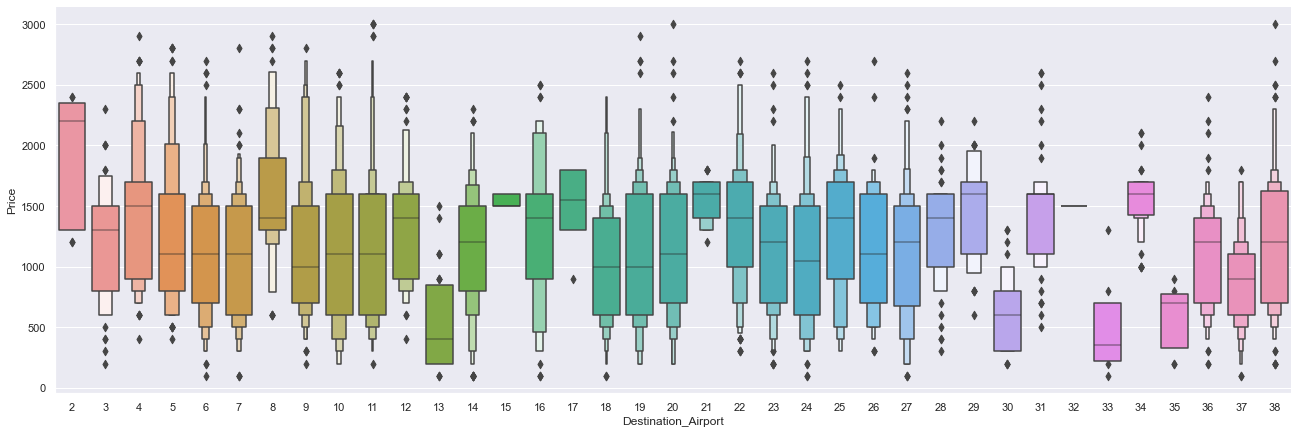

In [40]:
sns.set()
sns.catplot(y = "Price", x = "Destination_Airport", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

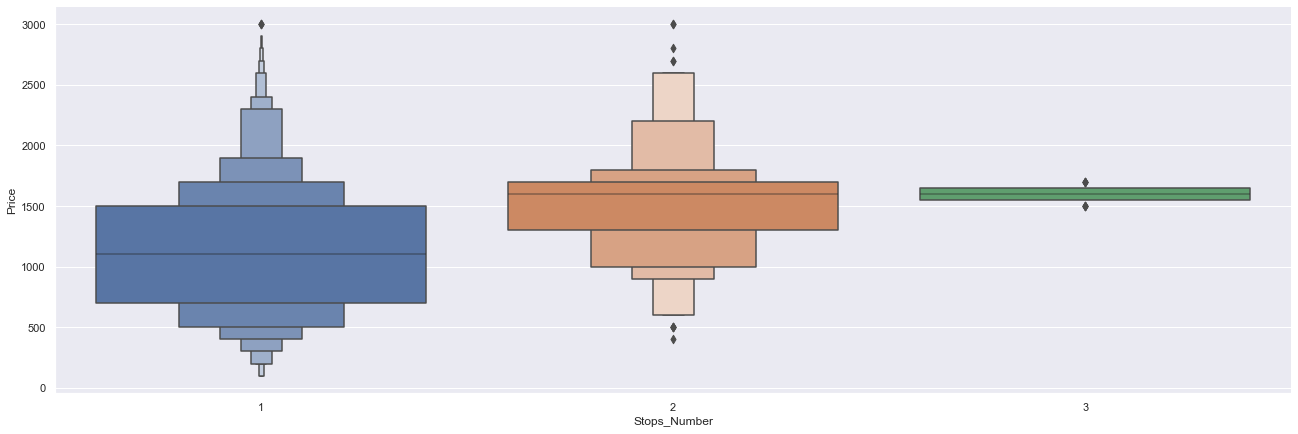

In [41]:
sns.set()
sns.catplot(y = "Price", x = "Stops_Number", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

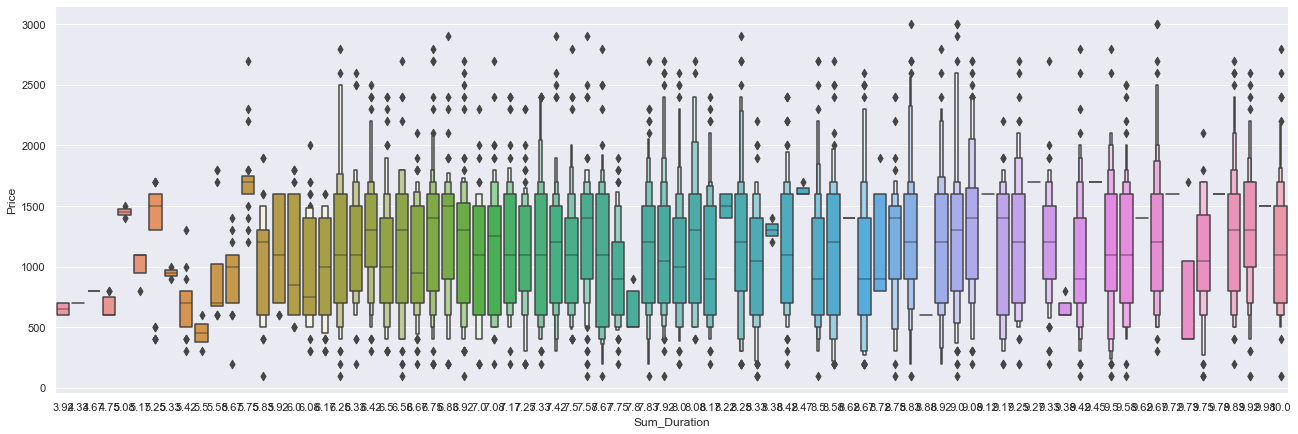

In [42]:
sns.set()
sns.catplot(y = "Price", x = "Sum_Duration", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

<AxesSubplot:ylabel='Destination_Airport'>

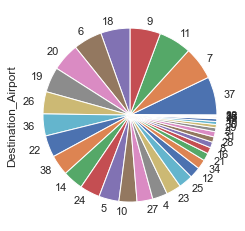

In [43]:
df['Destination_Airport'].value_counts().plot(kind='pie')

<AxesSubplot:>

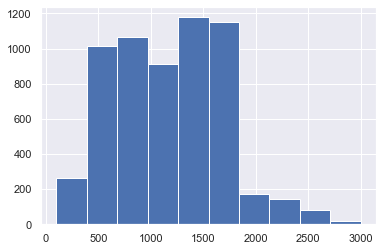

In [44]:
df['Price'].hist()

Model Building And data Creation
---------------------------------
After seeing some graphs that helped us better understand the data and their distribution, we will divide our data into a training and test group and start building the model.

In [45]:
def get_highly_correlated_cols(df):
    correlations =[]
    tuple_arr = []
    d = df.shape[1]
    df2 = df.corr(method='pearson')
    for i,col in enumerate(df2.columns):
        for j,col2 in enumerate(df2.columns):
            if i<j and df2.iloc[i,j]>=0.5:
                correlations.append(df2.iloc[i,j])
                tuple_arr.append((col,col2))           
    return correlations, tuple_arr

In [46]:
c,t = get_highly_correlated_cols(df)
for i in range(len(c)):
    print(f'{t[i]},\t\t {c[i]}')

('Dep_hour', 'Arr_hour'),		 0.7853912926020855


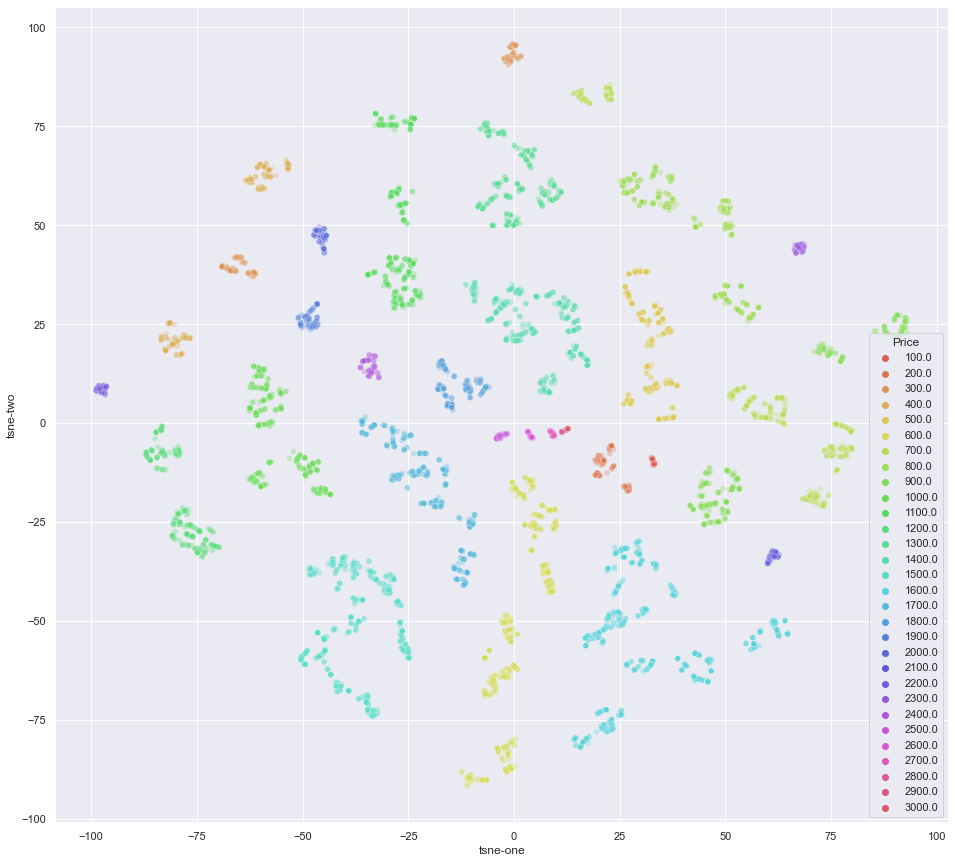

In [47]:
tsne = TSNE(n_components = 2)
tsne_result = tsne.fit_transform(df.values)
df['tsne-one'] = tsne_result[:,0]
df['tsne-two'] = tsne_result[:,1]
plt.figure(figsize=(16,15))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue=df['Price'],
    palette=sns.color_palette("hls", len(df.Price.unique())),
    data=df,
    legend="full",
    alpha=0.3)
df.drop('tsne-one', inplace=True, axis=1)
df.drop('tsne-two', inplace=True, axis=1)

In [48]:
def Plot_Graph(y_test, y_predict):
    number_of_observations=50
    x_ax = range(len(y_test[:number_of_observations]))
    plt.plot(x_ax,y_test[:number_of_observations], label='original')
    plt.plot(x_ax,y_predict[:number_of_observations], label='predicted')
    plt.title('Flight_Prediction')
    plt.xlabel('Observation Number')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [49]:
def Train_Test_Score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    train_score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    y_predict = model.predict(X_test).round(-2)
    Plot_Graph(y_test, y_predict)
    print('Train score :',train_score)
    print('Test score :',test_score)
    data = pd.DataFrame({'Predicted_Price':y_predict,
                      'Actual_Price':y_test})
    return data, model

In [50]:
X = df.drop('Price',axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [51]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

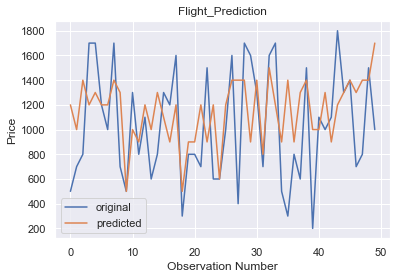

Train score : 0.2745118431727913
Test score : 0.27157265984312706


,Predicted_Price,Actual_Price
113,1200.0,500.0
15718,1000.0,700.0
3319,1400.0,800.0
11814,1200.0,1700.0
97,1300.0,1700.0
...,...,...
4086,1100.0,1600.0
10175,1200.0,1600.0
3109,1400.0,1200.0
1275,1100.0,1200.0


In [52]:
from sklearn.linear_model import LinearRegression
data, model = Train_Test_Score(LinearRegression(),X_train, X_test, y_train, y_test)
data

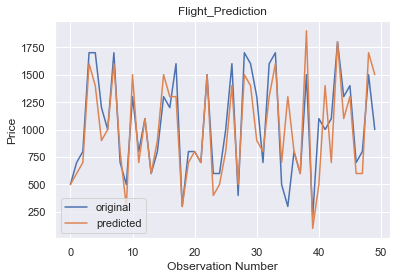

Train score : 0.5111193476649369
Test score : 0.285


,Predicted_Price,Actual_Price
113,500.0,500.0
15718,600.0,700.0
3319,700.0,800.0
11814,1600.0,1700.0
97,1400.0,1700.0
...,...,...
4086,700.0,1600.0
10175,1600.0,1600.0
3109,900.0,1200.0
1275,1200.0,1200.0


In [53]:
from sklearn.neighbors import KNeighborsClassifier
data, model = Train_Test_Score(KNeighborsClassifier(),X_train, X_test, y_train, y_test)
data

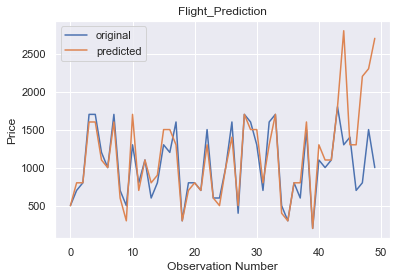

Train score : 0.8865826538176427
Test score : 0.415


,Predicted_Price,Actual_Price
113,500.0,500.0
15718,800.0,700.0
3319,800.0,800.0
11814,1600.0,1700.0
97,1600.0,1700.0
...,...,...
4086,700.0,1600.0
10175,1600.0,1600.0
3109,1000.0,1200.0
1275,1200.0,1200.0


In [54]:
from sklearn.ensemble import RandomForestClassifier
data, model = Train_Test_Score(RandomForestClassifier(),X_train, X_test, y_train, y_test)
data

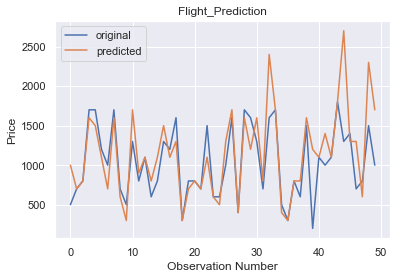

Train score : 0.8865826538176427
Test score : 0.38


,Predicted_Price,Actual_Price
113,1000.0,500.0
15718,700.0,700.0
3319,800.0,800.0
11814,1600.0,1700.0
97,1500.0,1700.0
...,...,...
4086,1100.0,1600.0
10175,1600.0,1600.0
3109,900.0,1200.0
1275,1200.0,1200.0


In [55]:
from sklearn.tree import DecisionTreeClassifier
data, model = Train_Test_Score(DecisionTreeClassifier(),X_train, X_test, y_train, y_test)
data

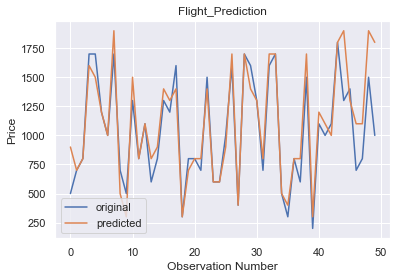

Train score : 0.9514032591003913
Test score : 0.7738980747524256


,Predicted_Price,Actual_Price
113,900.0,500.0
15718,700.0,700.0
3319,800.0,800.0
11814,1600.0,1700.0
97,1500.0,1700.0
...,...,...
4086,1100.0,1600.0
10175,1500.0,1600.0
3109,1100.0,1200.0
1275,1200.0,1200.0


In [56]:
from sklearn.ensemble import RandomForestRegressor
data, model = Train_Test_Score(RandomForestRegressor(n_estimators = 1009),X_train, X_test, y_train, y_test)
data

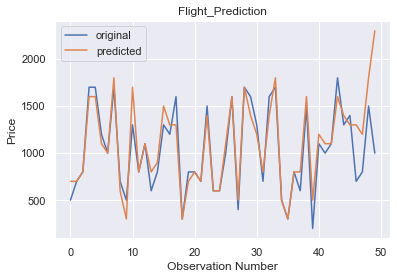

Train score : 0.9703580821680953
Test score : 0.7588131835330865


,Predicted_Price,Actual_Price
113,700.0,500.0
15718,700.0,700.0
3319,800.0,800.0
11814,1600.0,1700.0
97,1600.0,1700.0
...,...,...
4086,1300.0,1600.0
10175,1600.0,1600.0
3109,1100.0,1200.0
1275,1000.0,1200.0


In [57]:
from sklearn.ensemble import ExtraTreesRegressor
data, model = Train_Test_Score(ExtraTreesRegressor(),X_train, X_test, y_train, y_test)
data